In [ ]:
# !wget https://pixeldrain.com/api/file/wnUrWG2k?download
!unzip wnUrWG2k?download

In [ ]:
!pip install mtcnn

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import expand_dims

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError

import random

In [ ]:
validation = 0.2

In [ ]:
images = []
all_points = []

input_size = 256

base_path = 'WiderSelected/train'
with open(r'WiderSelected/annotations.txt') as f:
    while True:
        file_name = f.readline()[:-1]
        if not file_name:
            break
        # print(os.path.join(base_path, file_name))
        img = cv2.imread(os.path.join(base_path, file_name), cv2.IMREAD_GRAYSCALE)
        num = int(f.readline())
        for _ in range(num):
            labels_list = list(map(int, f.readline().split()))
            x, y, w, h = labels_list[:4]
            input = img[y:y+h, x:x+w]
            input = cv2.resize(input, (input_size, input_size))
            # plt.imshow(input)
            # plt.show()
            images.append(input/255.)
            points = np.array(labels_list[4:])
            points[0::2] = (points[0::2] - x) * input_size // w
            points[1::2] = (points[1::2] - y) * input_size // h 
            all_points.append(points)


images = np.array(images)
print(images.shape)
images = np.reshape(images, (-1, input_size, input_size, 1))
print(images.shape)

all_points = np.array(all_points)
print(all_points.shape)
all_points =  np.reshape(all_points, (-1, 68, 2))
print(all_points.shape)

ind = int(np.floor((1 - validation) * images.shape[0]))
x_train = images[:ind]
x_test = images[ind:]

all_points = all_points/input_size
all_points = np.reshape(all_points,(-1,136))
y_train = all_points[:ind]
y_test = all_points[ind:]


(6249, 256, 256)
(6249, 256, 256, 1)
(6249, 136)
(6249, 68, 2)


In [ ]:
def visualise_pts(img, ptss, title_num=0, color=False):
    titles = ["Ground Truth Points", "Predictions"]
    if not color: 
        img = img.reshape(input_size, input_size)
    plt.imshow(img, cmap='gray')
    plt.plot(ptss[:, 0], ptss[:, 1], '+r')
    plt.title(titles[title_num])
    plt.show()

# visualise_pts(images[3], all_points[3])


In [ ]:
def euclid_dist(pred_pts, gt_pts):
    """
    Calculate the euclidean distance between pairs of points
    :param pred_pts: The predicted points
    :param gt_pts: The ground truth points
    :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
    """
    pred_pts = np.reshape(pred_pts, (-1, 2))
    gt_pts = np.reshape(gt_pts, (-1, 2))
    return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))



In [ ]:
first_filters = 64
second_filters = 98
third_filters = 136

kernel_size = (3,3)
pool_size = (2,2)

inputs = Input(shape=(256,256,1), name="faces")
x1 = Conv2D(first_filters, kernel_size, activation="relu", input_shape=x_train.shape[1:])(inputs)
x2 =Conv2D(first_filters, kernel_size, activation="relu")(x1)
x3 = Conv2D(first_filters, kernel_size, activation="relu")(x2)
x4 = MaxPooling2D(pool_size=pool_size)(x3)

x5 = Conv2D(second_filters, kernel_size, activation="relu")(x4)
x6 = Conv2D(second_filters, kernel_size, activation="relu")(x5)
x7 = Conv2D(second_filters, kernel_size, activation="relu")(x6)
x8 = MaxPooling2D(pool_size=pool_size)(x7)

x9 = Flatten()(x8)
x10 = Dense(third_filters)(x9)
outputs = Activation("sigmoid")(x10)

model = Model(inputs=inputs, outputs=outputs)

loss_fn = MeanSquaredError()

# history = model.fit(x_train,y_train, epochs=5, batch_size=32, validation_data=(x_test,y_test))
optimizer = Adam(learning_rate=1e-3)

batch_size = 32
epochs = 2
shuffle_buffer_size = 100

data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
data_train = data_train.shuffle(shuffle_buffer_size).batch(batch_size)

# model = load_model('MyModel')
 

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(data_train):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
            print("Step: ", step, " ", "Loss: ", loss_value.numpy())

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

model.save('MyModel')            

In [ ]:
predictions = model.predict(x_test).reshape(-1,68,2) 
predictions *= 256
euclid_totals = []
for i in range(len(predictions)):
    euclid_totals.append(euclid_dist(predictions[i], y_test[i].reshape(68,2)*256))

acc = np.mean(euclid_totals)
print("Accuracy: ", acc)

Accuracy:  13.511749137528193


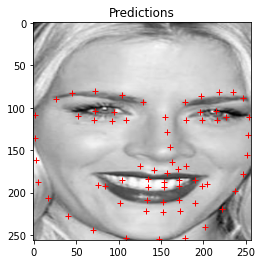

In [ ]:
visualise_pts(x_test[3], predictions[3], title_num=1)

1539 2053


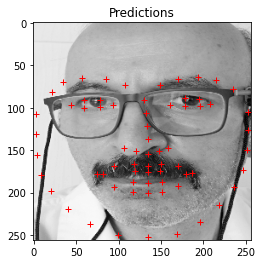

238 542 966 1238


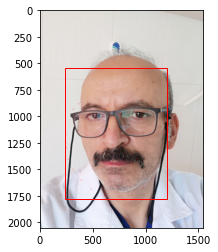

In [ ]:
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.pyplot import Rectangle, Circle

filename = '/content/IMG_20220704_115345.jpg'
 
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list, points):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        print(x, y, width, height)
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # # draw the box
        ax.add_patch(rect)
		    # draw the dots
        for pt in points:
            # create and draw dot
            dot = Circle((pt[0], pt[1]), radius=0.5, color='red')
            ax.add_patch(dot)
    # show the plot
    plt.show()

# load image from file
img = cv2.imread(filename)
height, width ,_ = img.shape
print(width, height)
pixels = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(img)
images = []
boxes = []
for face in faces:
    x, y, w, h = face['box']
    input = pixels[y:y+h, x:x+w]
    input = cv2.resize(input, (input_size, input_size))
    boxes.append(face['box'])
    images.append(input/255.)    

images = np.array(images)    
predict = (model.predict(images).reshape(-1,68,2))*256

visualise_pts(images[0], predict[0], title_num=1)

scaled_points = []
for i in range(predict.shape[0]):
    new_pts = []
    for j in range(68):
        new_pts.append(((predict[i][j][0]*boxes[i][2])/256)+boxes[i][0])
        new_pts.append(((predict[i][j][1]*boxes[i][3])/256)+boxes[i][1])
    scaled_points.append(new_pts)

scaled_points = np.array(scaled_points).astype('int32').reshape(-1, 2)
# print(scaled_points.shape)
# print(scaled_points[1,:4,:])
draw_image_with_boxes(filename, faces, scaled_points)
